In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

In [2]:
# Functions

# reverse the data of argument
def reverseData(data):
    data = data[::-1]
    return data

def getRound(data, decimals = 3):
    return np.around(data, decimals)

## given two curve a, b, then return the inversection point of two curves
def FindTheBuyPoint(a, b, mode):
    if(mode == "rsi_1"):
        buyPoint = np.argwhere(np.diff(np.sign(a - 20)) < 0).reshape(-1) + 0
    else:
        buyPoint = np.argwhere(np.diff(np.sign(a - b)) > 0).reshape(-1) + 0
    return buyPoint

def FindTheSellPoint(a, b, mode):
    if(mode == "rsi_1"):
        sellPoint = np.argwhere(np.diff(np.sign(a - 80)) > 0).reshape(-1) + 0
    else:
        sellPoint = np.argwhere(np.diff(np.sign(a - b)) < 0).reshape(-1) + 0
    return sellPoint

def GetDataFromDB(ip, userName, psw, tableName, sql):
    try:
        db = pymysql.connect(ip, userName, psw, tableName)
    except:
        print ("Error: unable to connect to DB")
        
    #create a cursor
    cursor = db.cursor()
    results = []
    try:
        cursor.execute(sql)
        results = cursor.fetchall()
    except:
        print ("Error: unable to fetch data from DB")
    
    return results
    db.close()

def SMA(data, period):
    if (type(data) == pd.core.series.Series):
        return data.rolling(window = period).mean()
    else:
        print ("Error: Wrong input, SMA(pandas.core.series.Series, integer)")
        
def EMA(data, period):
    if (type(data) == pd.core.series.Series):
        return data.ewm(span = period, adjust = False).mean()
    else:
        print ("Error: Wrong input, EMA(pandas.core.series.Series, integer)")
        
def RSI(data, period):
    if (type(data) == pd.core.series.Series):
        delta = data.diff()
        up, down = delta.copy(), delta.copy()

        up[up < 0] = 0
        down[down > 0] = 0
        down = abs(down)
        
        Up = SMA(up, period)
        Up = Up.fillna(0)
        for i in range(period,len(Up)):
            Up[i] = getRound((Up[i - 1] * (period - 1) + up[i]) / period)

        Down = SMA(down, period)
        Down = Down.fillna(0)
        for i in range(period,len(Down)):
            Down[i] = getRound((Down[i - 1] * (period - 1) + down[i]) / period)


        rsi = 100 * (Up / (Up + Down))
        rsi = rsi.fillna(0)
        return getRound(rsi, 2)
    else:
        print ("Error: Wrong input, RSI(pandas.core.series.Series, integer)")
        
def MACD(data, period = []):
    if (type(data) == pd.core.frame.DataFrame and len(period) == 3):   
        di = (data['High'] + data['Low'] + 2.0 * data['Close']) / 4.0
        ema12 = SMA(di, period[0])
        ema12 = ema12.fillna(0)
        for i in range(period[0] + 1, len(ema12)):
            ema12[i] = (ema12[i - 1] * (period[0] - 1) + di[i] * 2.0) / (period[0] + 1)
    
        ema26 = SMA(di, period[1])
        ema26 = ema26.fillna(0)
        for i in range(period[1] + 1, len(ema26)):
            ema26[i] = (ema26[i - 1] * (period[1] - 1) + di[i] * 2.0) / (period[1] + 1)
    
        dif = ema12 - ema26

        dem = SMA(dif, period[2])
        dem = dem.fillna(0)
        for i in range(period[2] + 1, len(dem)):
            dem[i] = (dem[i - 1] * (period[2] - 1) + dif[i] * 2.0) / (period[2] + 1)
        return {'dif':dif, 'dem':dem}
    else:
        if(type(data) == pd.core.frame.DataFrame):
            print ("Error: Wrong input, MACD(pandas.core.frame.DataFrame, list of integer)")
        elif(len(period) == 3):
            print ("Error: number of content in list do not equal to 3")
            
def KD(data, result = {}):
    close = data['收盤價(元)'].copy()
    for i in range(0,9):
        close[i] = 0

    data['RSV'] = (( data['收盤價(元)'] - data['最低價(元)'].rolling(window = 9).min()) / (data['最高價(元)'].rolling(window = 9).max() - data['最低價(元)'].rolling(window = 9).min()))
    data['RSV'] = data['RSV'].fillna(0)
    if(not result):
        result = {
            'K9':[0],
            'D9' :[0]
        }
    #calculate everyday's KD
    for i in range(1, len(data.index)):
        K9_value = (1.0/3.0) * data['RSV'][i] + (2.0 / 3.0) * result['K9'][i - 1]
        result['K9'].append(getRound(K9_value, 5))
        D9_value = (2.0/3.0) * result['D9'][i - 1] + (1.0 / 3.0) * result['K9'][i]
        result['D9'].append(getRound(D9_value, 5))
        
    return result

In [5]:
# get data
etfPriceData = pd.read_csv(r"C:\Users\user\Dropbox\taetfp.csv", encoding="big5")
etfPriceData.head(1317)

,代碼,日期,中文簡稱,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
0,50,20130102,元大台灣50,46.57,47.13,46.49,46.92,"16,487"
1,50,20130103,元大台灣50,47.35,47.48,47.13,47.31,"29,020"
2,50,20130104,元大台灣50,47.31,47.31,46.92,47.00,"9,837"
3,50,20130107,元大台灣50,47.05,47.05,46.49,46.79,"8,910"
4,50,20130108,元大台灣50,46.57,46.75,46.27,46.49,"12,507"
5,50,20130109,元大台灣50,46.36,46.83,46.36,46.66,"7,529"
6,50,20130110,元大台灣50,46.83,47.13,46.70,47.00,"13,953"
7,50,20130111,元大台灣50,47.18,47.26,46.87,46.96,"11,837"
8,50,20130114,元大台灣50,46.57,47.00,46.40,47.00,"7,282"
9,50,20130115,元大台灣50,46.75,46.96,46.49,46.57,"6,609"


In [6]:
# kd
KD_result = pd.DataFrame(KD(etfPriceData))
# kd's long points & short points
KD_long = FindTheBuyPoint(KD_result['K9'], KD_result['D9'], "kd")
KD_short = FindTheSellPoint(KD_result['K9'], KD_result['D9'], "kd")

# create a long/short points list
KD_result = [[0] for i in range(len(KD_result))]

for i in KD_long:
    KD_result[i][0] = 1
for i in KD_short:
    KD_result[i][0] = -1

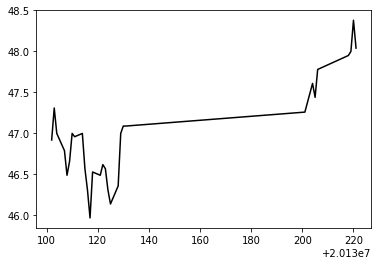

In [7]:
# Draw kd result
x = list(etfPriceData['日期'].head(30))
y1 = list(etfPriceData['收盤價(元)'].head(30))

plt.plot(x, y1, "k")

In [8]:
# rsi
rsi5_result = pd.DataFrame(RSI(etfPriceData['收盤價(元)'], 5))
rsi5_result = rsi5_result.rename(columns={'收盤價(元)': 'rsi'})

rsi14_result = pd.DataFrame(RSI(etfPriceData['收盤價(元)'], 14))
rsi14_result = rsi14_result.rename(columns={'收盤價(元)': 'rsi'})

# rsi's long points & short points
rsi_long_with1curve = FindTheBuyPoint(rsi14_result['rsi'], [], "rsi_1")
rsi_short_with1curve = FindTheSellPoint(rsi14_result['rsi'], [], "rsi_1")

rsi_long_with2curve = FindTheBuyPoint(rsi5_result['rsi'], rsi14_result['rsi'], "rsi_2")
rsi_short_with2curve = FindTheSellPoint(rsi5_result['rsi'], rsi14_result['rsi'], "rsi_2")

# create a long/short points list
rsi1curve_result = [[0] for i in range(len(rsi14_result))]
rsi2curve_result = [[0] for i in range(len(rsi14_result))]

for i in rsi_long_with1curve:
    rsi1curve_result[i][0] = 1
for i in rsi_short_with1curve:
    rsi1curve_result[i][0] = -1
for i in rsi_long_with2curve:
    rsi2curve_result[i][0] = 1
for i in rsi_short_with2curve:
    rsi2curve_result[i][0] = -1

In [9]:
# Draw rsi result

In [10]:
# sma
sma_result_5 = pd.DataFrame(SMA(etfPriceData['收盤價(元)'], 5))
sma_result_10 = pd.DataFrame(SMA(etfPriceData['收盤價(元)'], 10))
sma_result_5 = sma_result_5.rename(columns={'收盤價(元)':'sma5'})
sma_result_10 = sma_result_10.rename(columns={'收盤價(元)':'sma10'})

sma_result_20 = pd.DataFrame(SMA(etfPriceData['收盤價(元)'], 20))
sma_result_60 = pd.DataFrame(SMA(etfPriceData['收盤價(元)'], 60))
sma_result_20 = sma_result_20.rename(columns={'收盤價(元)':'sma20'})
sma_result_60 = sma_result_60.rename(columns={'收盤價(元)':'sma60'})

sma_result_120 = pd.DataFrame(SMA(etfPriceData['收盤價(元)'], 120))
sma_result_240 = pd.DataFrame(SMA(etfPriceData['收盤價(元)'], 240))
sma_result_120 = sma_result_120.rename(columns={'收盤價(元)':'sma120'})
sma_result_240 = sma_result_240.rename(columns={'收盤價(元)':'sma240'})

sma_result_5.fillna(value=0, inplace=True)
sma_result_10.fillna(value=0, inplace=True)
sma_result_20.fillna(value=0, inplace=True)
sma_result_60.fillna(value=0, inplace=True)
sma_result_120.fillna(value=0, inplace=True)
sma_result_240.fillna(value=0, inplace=True)

# sma's long points & short points
smas_long = FindTheBuyPoint(sma_result_5['sma5'], sma_result_10['sma10'], "sma")
smas_short = FindTheSellPoint(sma_result_5['sma5'], sma_result_10['sma10'], "sma")

smam_long = FindTheBuyPoint(sma_result_20['sma20'], sma_result_60['sma60'], "sma")
smam_short = FindTheSellPoint(sma_result_20['sma20'], sma_result_60['sma60'], "sma")

smal_long = FindTheBuyPoint(sma_result_120['sma120'], sma_result_240['sma240'], "sma")
smal_short = FindTheSellPoint(sma_result_120['sma120'], sma_result_240['sma240'], "sma")

# create a long/short points list
smas_result = [[0] for i in range(len(sma_result_5))]
smam_result = [[0] for i in range(len(sma_result_5))]
smal_result = [[0] for i in range(len(sma_result_5))]

for i in smas_long:
    smas_result[i][0] = 1
for i in smas_short:
    smas_result[i][0] = -1
for i in smam_long:
    smam_result[i][0] = 1
for i in smam_short:
    smam_result[i][0] = -1
for i in smal_long:
    smal_result[i][0] = 1
for i in smal_short:
    smal_result[i][0] = -1

In [11]:
# Draw sma result

In [ ]:
# macd
MACD_result = pd.DataFrame(MACD(etfPriceData, [12,26,9]))
# kd's long points & short points
MACD_long = FindTheBuyPoint(MACD_result['dif'], MACD_result['dem'], "macd")
MACD_short = FindTheSellPoint(MACD_result['dif'], MACD_result['dem'], "macd")

# create a long/short points list
MACD_result = [[0] for i in range(len(MACD_result))]

for i in MACD_long:
    MACD_result[i][0] = 1
for i in MACD_short:
    MACD_result[i][0] = -1

In [8]:
csvHeader = ['sma_shorterm', 'sma_midterm', 'sma_longterm']
file = open(r"C:\Users\vm06v\OneDrive\桌面\indicator.csv", "w", newline = '')
cursor = csv.writer(file)
cursor.writerow(csvHeader)
for i in range(len(smas_result)):
    cursor.writerow([smas_result[i][0], smam_result[i][0], smal_result[i][0]])